In [5]:
from pydantic import BaseModel, ConfigDict, Field
import numpy as np
from itertools import product
from random import choices
import matplotlib.pyplot as plt


In [32]:
INIT_VEL = np.zeros(2, dtype=np.float32)
MAX_SPEED: np.float32 = np.float32(5)
MAX_FORCE: np.float32 = np.float32(2)

## Boids implementation

In [7]:
class Boid(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    position: np.ndarray
    velocity: np.ndarray

class Swarm:
    def __init__(self, n: int, x_max: int, y_max: int) -> list[Boid]:
        xs, ys = np.meshgrid(np.arange(x_max, dtype=np.float32), np.arange(y_max, dtype=np.float32))
        pairs = np.column_stack((xs.ravel(), ys.ravel()))
        idxs = np.random.choice(x_max * y_max, size=n, replace=False)
        self._swarm =  [Boid(position=pairs[i], velocity=INIT_VEL) for i in idxs]
        self.x_limits = (0.0, x_max)
        self.y_limits = (0.0, y_max)

    @staticmethod
    def in_radius(x: Boid, y: Boid, r: float):
        return np.sqrt(np.sum((x.position-y.position)**2)) <= r


    def _get_neighbours(self, target: Boid, radius: float) -> list[Boid]:
        neighbours: list[Boid] = []
        for boid in self._swarm:
            if Swarm.in_radius(target, boid, radius) and boid is not target:
                neighbours.append(boid)
        return neighbours
    

    def update_pos(self, rules: "Rules",  max_speed=MAX_SPEED):
        self._update_vel(rules, max_speed)
        for boid in self._swarm:
            boid.position += boid.velocity
            if boid.position[0] < self.x_limits[0] or boid.position[0] > self.x_limits[1]:
                boid.velocity[0] *= -1
                boid.position[0] = np.clip(boid.position[0], *self.x_limits)
            if boid.position[1] < self.y_limits[0] or boid.position[1] > self.y_limits[1]:
                boid.velocity[1] *= -1
                boid.position[1] = np.clip(boid.position[1], *self.y_limits)
        
    def _update_vel(self, rules: "Rules", max_speed=MAX_SPEED):
        for boid, acc in zip(self._swarm, self.get_acc(rules)):
            boid.velocity += acc
            speed = np.linalg.norm(boid.velocity)
            if speed > max_speed:
                boid.velocity = boid.velocity / speed * max_speed

    def get_acc(self, rules) -> list[np.ndarray]:
        accs = []
        for boid in self._swarm:
            sep = self._compute_sepataion(boid, rules.rs, rules.ws)
            ali = self._compute_allignment(boid, rules.ra, rules.wa)
            coh = self._compute_coheison(boid, rules.rc, rules.wc)
            acc = sep + ali + coh
            accs.append(acc)
        return accs
    
    def _compute_sepataion(self, target: Boid, rs: float, ws: float) -> np.float32:
        neighbours = self._get_neighbours(target, rs)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_pos = np.array([b.position for b in neighbours])
        direction_away = target.position - neighbours_pos
        dist = np.linalg.norm(direction_away, axis=1)
        sep = direction_away / dist[:, None]
        return np.sum(sep, axis=0) * ws

    def _compute_allignment(self, target: Boid, ra: float, wa: float) -> np.float32:
        neighbours = self._get_neighbours(target, ra)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_vel = np.array([b.velocity for b in neighbours])
        avg_vel = np.mean(neighbours_vel, axis=0)
        return (avg_vel - target.velocity) * wa

    def _compute_coheison(self, target: Boid, rc: float, wc: float) -> np.float32:
        neighbours = self._get_neighbours(target, rc)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_pos = np.array([b.position for b in neighbours])
        center = np.mean(neighbours_pos, axis=0)
        return (center - target.position) * wc


class Rules(BaseModel):
    rs: float = Field(description="radius for separation")
    ws: float = Field(description="weight for separation")
    ra: float = Field(description="radius for alignment")
    wa: float = Field(description="weight for alignment")
    rc: float = Field(description="radius for cohesion")
    wc: float = Field(description="weight for cohesion")

    

class World:
    def __init__(self, size: int) -> None:
        self._size = size
        self._boids: list[Boid] = []
        self._rules: Rules | None = None

    def set_swarm(self, swarm: list[Boid]) -> None:
        self._boids = swarm

    def set_rules(self, rules: Rules) -> None:
        self._rules = rules

    def step(self):
        accs = self._swarm.update_acc(self._rules)
        self._swarm.update_pos(accs)

    def draw(self):
        xs = [b.position[0] for b in self._boids]
        ys = [b.position[1] for b in self._boids]

        plt.scatter(xs, ys)
        plt.xlim(0, self._size)
        plt.ylim(0, self._size)
        plt.show()

In [8]:
class World:
    def __init__(self, size: float, swarm: Swarm, rules: Rules) -> None:
        self._size = size
        self._swarm = swarm
        self._rules = rules

    def step(self):
        self._swarm.update_pos(self._rules)

    def draw(self):
        xs = [b.position[0] for b in self._swarm._swarm]
        ys = [b.position[1] for b in self._swarm._swarm]
        plt.scatter(xs, ys, color="blue", s=50)
        plt.xlim(0, self._size)
        plt.ylim(0, self._size)
        plt.show()

    def animate(self, frames: int = 200, interval: int = 50, save_path: str | None = None):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(0, self._size)
        ax.set_ylim(0, self._size)
        ax.set_xticks([])
        ax.set_yticks([])

        xs = [b.position[0] for b in self._swarm._swarm]
        ys = [b.position[1] for b in self._swarm._swarm]
        scat = ax.scatter(xs, ys, s=40)

        def update(frame):
            self.step()
            xs = [b.position[0] for b in self._swarm._swarm]
            ys = [b.position[1] for b in self._swarm._swarm]
            scat.set_offsets(list(zip(xs, ys)))
            ax.set_title(f"Boids — frame {frame+1}")
            return scat,

        anim = animation.FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
        
        if save_path is not None:
            writer = animation.PillowWriter(fps=15)
            anim.save(save_path, writer=writer, dpi=150)
            print(f"Saved animation to {save_path}")
        else:
            plt.show()

Saved animation to boids.gif


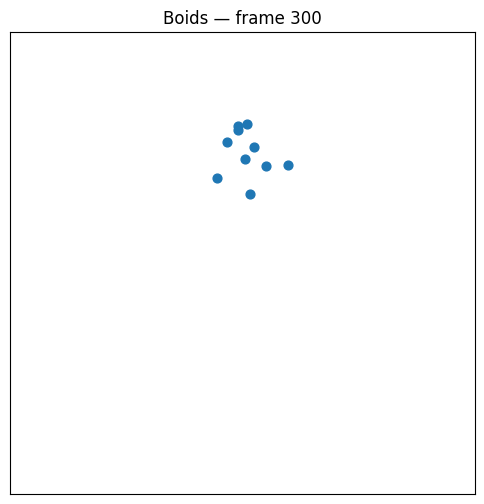

In [9]:
swarm = Swarm(n=10, x_max=10, y_max=10)
# for b in swarm._swarm:
    # b.velocity = np.random.rand(2) * 1 - 0.5
rules = Rules(
    rs=0.0, ws=0.02,
    ra=0.0, wa=0.0,
    rc=5.0, wc=1.000,
)
world = World(size=10, swarm=swarm, rules=rules)
world.animate(frames=300, interval=50, save_path="boids.gif")


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import os

dt = 0.1
frames = 240

def limit_vector(v, max_val):
    norm = np.linalg.norm(v)
    if norm > max_val and norm > 0:
        return v / norm * max_val
    return v

class Boids:
    """Optimised version of boids based mainly on numpy."""
    def __init__(
        self,
        boids_no: int,
        board_width: int,
        board_height: int,
        seed: int | None = None
    ) -> None:
        self.rng = np.random.default_rng(seed)
        self.boids_pos = self.rng.random(size=(boids_no, 2), dtype=np.float32) * np.array([board_width, board_height])
        boids_angles = self.rng.random(size=boids_no) * 2 * np.pi
        self.boids_vel = np.column_stack((
            np.cos(boids_angles),
            np.sin(boids_angles),
        )) * (0.5 + self.rng.random(size=boids_no) * 10.0)[:, None]

        self.height = board_height
        self.width = board_width
        self._rules: Rules | None = None
    
    def set_rules(self, rules: Rules) -> None:
        self._rules = rules
    
    def step(self, dt: float):
        acc = self.get_acc()
        self.boids_vel += acc * dt
        speeds = np.linalg.norm(self.boids_vel, axis=1)
        for i in range(len(self.boids_vel)):
            if speeds[i] > MAX_SPEED:
                self.boids_vel[i] = self.boids_vel[i] / speeds[i] * MAX_SPEED
        self.boids_pos = (self.boids_pos + self.boids_vel * dt) % np.array([self.width, self.height])


    
    def get_acc(self) -> np.ndarray:
        acc = np.zeros((len(self.boids_pos), 2), dtype=np.float32)
        for idx, (p_i, v_i) in enumerate(zip(self.boids_pos, self.boids_vel)):
            # Differences with wrapping (toroidal)
            diff = self.boids_pos - p_i
            diff[:,0] = (diff[:,0] + self.width/2) % self.width - self.width/2
            diff[:,1] = (diff[:,1] + self.height/2) % self.height - self.height/2
            dists = np.linalg.norm(diff, axis=1)

            ali_neighbors = (dists > 0) & (dists < self._rules.ra)
            coh_neighbors = (dists > 0) & (dists < self._rules.rc)
            sep_neighbors = (dists > 0) & (dists < self._rules.rs)

            steer_align = self._get_alignment(v_i, ali_neighbors)
            steer_cohesion = self._get_cohesion(v_i, p_i, diff, coh_neighbors)
            steer_separation = self._get_separation(diff, dists, sep_neighbors)

            force = (self._rules.wa * steer_align +
                    self._rules.wc * steer_cohesion +
                    self._rules.ws * steer_separation)
            acc[idx] = force
        return acc
    
    def _get_alignment(self, v_i: np.ndarray, neighbors: np.ndarray) -> np.float32:
        if np.any(neighbors):
            avg_vel = self.boids_vel[neighbors].mean(axis=0)
            steer_align = avg_vel - v_i
            steer_align = limit_vector(steer_align, MAX_FORCE)
        else:
            steer_align = np.zeros(2)
        return steer_align
    
    def _get_cohesion(self, v_i: np.ndarray, p_i: np.ndarray, diff: np.ndarray, neighbors: np.ndarray) -> np.float32:
        if np.any(neighbors):
            center_offset = diff[neighbors].mean(axis=0)
            center = p_i + center_offset
            desired = center - p_i
            steer_cohesion = desired - v_i
            steer_cohesion = limit_vector(steer_cohesion, MAX_FORCE)
        else:
            steer_cohesion = np.zeros(2)
        return steer_cohesion
    
    def _get_separation(self, diff: np.ndarray, dists: np.ndarray, neighbors: np.ndarray) -> np.float32:
        if np.any(neighbors):
            close = diff[neighbors]
            close_d = dists[neighbors][:, None]
            push = -np.sum(close / (close_d**2 + 1e-6), axis=0)
            steer_separation = limit_vector(push, MAX_FORCE)
        else:
            steer_separation = np.zeros(2)
        return steer_separation
    
    def animate(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])

        scat = ax.scatter(self.boids_pos[:, 0], self.boids_pos[:, 1], s=40)
        quiv = ax.quiver(
            self.boids_pos[:, 0],
            self.boids_pos[:, 1],
            self.boids_vel[:, 0],
            self.boids_vel[:, 1],
            angles='xy',
            scale_units='xy',
            scale=1.5
        )

        def update(frame):
            self.step(dt)
            scat.set_offsets(self.boids_pos)
            quiv.set_offsets(self.boids_pos)
            quiv.set_UVC(self.boids_vel[:, 0], self.boids_vel[:, 1])
            ax.set_title(f"Boids — frame {frame+1}/{frames}")
            return scat, quiv

        # --- FIX: create animation object ---
        anim = animation.FuncAnimation(
            fig,
            update,
            frames=frames,
            interval=1000/30,
            blit=False
        )

        outdir = "boids_output"
        os.makedirs(outdir, exist_ok=True)

        gif_path = os.path.join(outdir, "boids.gif")
        mp4_path = os.path.join(outdir, "boids.mp4")

        print("Saving GIF:", gif_path)
        writer = PillowWriter(fps=30)
        anim.save(gif_path, writer=writer, dpi=150)

        try:
            anim.save(mp4_path, fps=30, dpi=150)
            print("Saved MP4:", mp4_path)
        except Exception as e:
            print("MP4 save failed:", e)

        plt.close(fig)
        

In [42]:
boids = Boids(
    boids_no=60,
    board_width=30,
    board_height=30,
)
rules = Rules(
    rs=0.0, ws=0.0,
    ra=1.0, wa=1,
    rc=0, wc=0,
)
boids.set_rules(rules)
boids.animate()

Saving GIF: boids_output/boids.gif
Saved MP4: boids_output/boids.mp4
